In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2, os
import pandas as pd
from scipy.interpolate import interp1d
from scipy import interpolate
import torch

## Patch Hyperspectral Reflectance

In [2]:
"""

    Create HDR image under two circumstances
        1. pattern intensity 20%, camera exposure 160ms
        2. pattern intensity 80%, camrea exposure 320ms
        
        We need to normalize images, both exposure and intensity : exposure weight & radiance weight (by classic colorchecker)
        
    
    Handling invalid intensity (etc. saturation) : using weight trapezoid
    
"""

'\n\n    Create HDR image under two circumstances\n        1. pattern intensity 20%, camera exposure 160ms\n        2. pattern intensity 80%, camrea exposure 320ms\n        \n        We need to normalize images, both exposure and intensity : exposure weight & radiance weight (by classic colorchecker)\n        \n    \n    Handling invalid intensity (etc. saturation) : using weight trapezoid\n    \n'

## ldr2hdr

In [4]:
# arguments
cam_H, cam_W = 580, 890
wvls = np.arange(430, 670, 10) # 430nm 부터 시작

n_illum = 318
n_patches = 24
n_channel = 3

patch_idx = np.arange(0, 24)
patch_size = 3

### Gamma correction

In [5]:
# # load gamma rgb fitting coefficients
# rgb_fit = io.loadmat("./calibration/gamma_correction.mat")

# # define coefficients for all rgb channel
# a = rgb_fit['a']
# b = rgb_fit['b']
# c = rgb_fit['c']

# # gamma correction
# y = a*(y_linear**b)+c

# # stack for 3 channels
# rgb_gamma_corrected = y

### ldr2hdr Preprocess

In [6]:
# date of datas
date = "1029_tree"

idx_minmax = 1

# exposure times
ex_time = np.array([160, 320])
ex_min = ex_time[idx_minmax]
# exposure weight
exposure = ex_time / ex_min

# rgb intensity
intensity = np.array([0.2, 0.8])

ldr2hdr_dir = "./dataset/data/2023%s_real_data/"%date

# RGB normalization pixel point
last_row_center_pts = np.array([45, 393]) # black patch of a classic color checker

In [7]:
# safe subtraction for uint16
def safe_subtract(a,b):
    # difference = np.abs(a.astype(np.int16) - b.astype(np.int16))
    
    difference = np.where(a>b, a-b, 0)
    difference = np.clip(np.round(difference), 0, 65535).astype(np.uint16)    
    
    return difference.astype(a.dtype)

In [8]:
# radiance weight for intensity normalization
def cal_radiance_weight(exp_images_bgrm): # exposure 개수, H, W, 3
    radiance_values = np.zeros(shape=(len(exp_images_bgrm), 3))
    
    p_size = 5
    
    for i in range(len(exp_images_bgrm)):
        y_idx_start, y_idx_end = (last_row_center_pts[1] - p_size//2).astype(np.int32), (last_row_center_pts[1] + p_size//2).astype(np.int32)
        x_idx_start, x_idx_end = (last_row_center_pts[0] - p_size//2).astype(np.int32), (last_row_center_pts[0] + p_size//2).astype(np.int32)
        
        radiance_values[i] = exp_images_bgrm[i][y_idx_start:y_idx_end, x_idx_start:x_idx_end].mean(axis = (0,1))
    
    return (radiance_values / radiance_values[idx_minmax])

# calculate radiance_weight
exp_img_path = os.path.join(ldr2hdr_dir, 'intensity_%d_white_crop/calibration00/capture_%04d.png')
exp_img_black_path = os.path.join(ldr2hdr_dir, 'step2_%sms_black_crop/calibration00/capture_%04d.png')

exp_images = np.array([cv2.imread(exp_img_path%(intensity[k]*100, 0), -1)[:,:,::-1] for k in range(len(intensity))])
exp_black_images = np.array([cv2.imread(exp_img_black_path%(ex_time[0], 0), -1)[:,:,::-1] for k in ex_time])

# remove black image
exp_images_bgrm = safe_subtract(exp_images, exp_black_images)

# radiance weight
radiance_weight = cal_radiance_weight(exp_images_bgrm)

In [9]:
1/radiance_weight

array([[21.40724947, 20.935769  , 23.13894523],
       [ 1.        ,  1.        ,  1.        ]])

In [10]:
# assumes that we have the uint16 LDR images 
# image intensity weight

invalid_intensity_ratio = 0.01 # 0 < invalid_intensity_ratio: invalid,  out of 1

max_intensity = 2**16
weight_trapezoid = np.zeros(max_intensity)
intv = float(max_intensity) * invalid_intensity_ratio

for i in range(max_intensity):
    if i < intv:
        weight_trapezoid[i] = 0  
    elif i < intv * 2:
        weight_trapezoid[i] = (i - intv) / intv
    elif i < max_intensity - (intv * 2):
        weight_trapezoid[i] = 1
    elif i < max_intensity - intv:
        weight_trapezoid[i] = (max_intensity - intv - i) / intv
    else:
        weight_trapezoid[i] = 0

In [11]:
# assumes that we have the uint16 LDR images 
# black removed image intensity weight

invalid_intensity_ratio = 0.01  # 0 < invalid_intensity_ratio: invalid,  out of 1

max_intensity = 2**16
weight_trapezoid_bgrm = np.zeros(max_intensity)
intv = float(max_intensity) * invalid_intensity_ratio

for i in range(max_intensity):
    if i < intv: # 3 
        weight_trapezoid_bgrm[i] = 0  
    elif i < intv * 2:
        weight_trapezoid_bgrm[i] = (i - intv) / intv
    else:
        weight_trapezoid_bgrm[i] = 1

### Make hdr

In [12]:
def make_hdr(ldr_images, ldr_images_bgrm, weight_trapezoid, exposure):
    """
        weighted images for ldr image and black image removed ldr image
        black image를 뺀 애는 saturation이 일어난 ldr image에서 intensity가 내려가기 때문에 사실 
        saturation이 일어나서 얘를 weight 를 0을 줘야함. 근데 bgrm에만 기준으로 weight가 정해지면
        saturation 일어난 애에서 제거가 불가능
    """
    weighted_images = [weight_trapezoid[image] for image in ldr_images]
    weighted_images_bgrm = [weight_trapezoid_bgrm[image] for image in ldr_images_bgrm]
    
    # take the minimum weight 
    weighted_images_final = np.minimum(weighted_images, weighted_images_bgrm)
    
    # exposure & intensity normalization
    radiance_images = [np.multiply(weighted_images_final[i], ldr_images_bgrm[i] / (radiance_weight[i] * exposure[i])) for i in range(len(ldr_images_bgrm))]

    # intensity normalization
    weight_sum_image = np.sum(weighted_images_final, axis=0)
    radiance_sum_image = np.sum(radiance_images, axis=0)

    idx_invalid = (weight_sum_image == 0)
    weight_sum_image[idx_invalid] = 1
    radiance_sum_image[idx_invalid] = 0    
    
    return np.divide(radiance_sum_image, weight_sum_image), idx_invalid, weight_sum_image

#### Raidance weight debugging

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


original :  [3.2627451  7.27843137 3.51372549]
normalized :  [ 69.84639826 152.37955793  81.30390168]
original :  [ 76.8        138.54117647  88.47058824]
normalized :  [ 76.8        138.54117647  88.47058824]


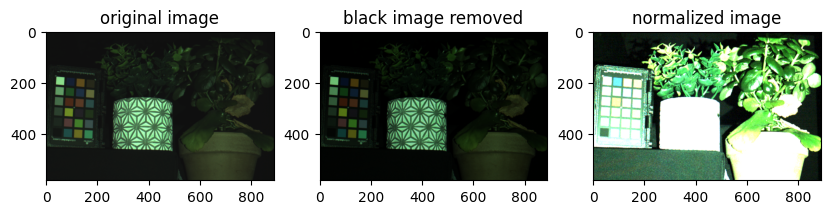

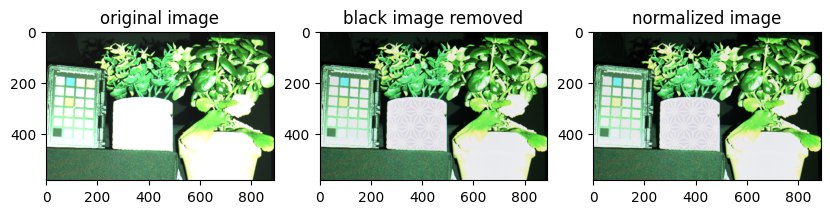

In [13]:
for i in range(len(exp_images)):
    plt.figure(figsize=(10, 5))
    plt.subplot(131), plt.imshow(exp_images[i]/65535), plt.title('original image')
    plt.subplot(132), plt.imshow((exp_images_bgrm[i]/ 65535)), plt.title('black image removed')
    plt.subplot(133), plt.imshow((exp_images_bgrm[i]*(1/radiance_weight[i]))/ 65535), plt.title('normalized image')
    print('original : ', (exp_images_bgrm[i][last_row_center_pts[1], last_row_center_pts[0]]/ 255))
    print('normalized : ', (exp_images_bgrm[i][last_row_center_pts[1], last_row_center_pts[0]] * (1/radiance_weight[i]))/ 255)
    plt.savefig('normalization.svg')

(<matplotlib.image.AxesImage at 0x1da0d3a7fc8>,
 Text(0.5, 1.0, 'original image'))

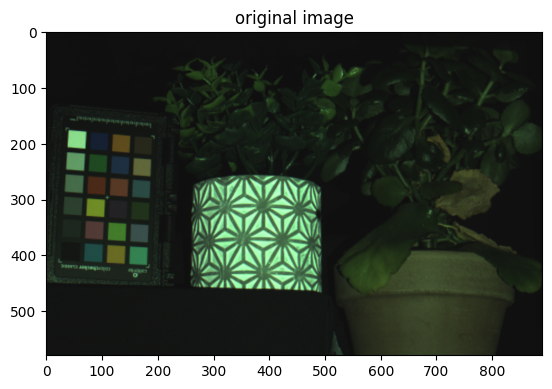

In [14]:
plt.imshow((exp_images[0]/65535)), plt.title('original image')

#### Debugging (Not Essential)

In [15]:
ldr_path = os.path.join(ldr2hdr_dir, 'step2_%sms_crop/calibration00/capture_%04d.png')
black_path = os.path.join(ldr2hdr_dir, 'step2_%sms_black_crop/calibration00/capture_%04d.png')

i = 280

ldr_images = np.array([cv2.imread(ldr_path%(k, i), -1)[:,:,::-1] for k in ex_time])
ldr_black_images = np.array([cv2.imread(black_path%(k, 0), -1)[:,:,::-1] for k in ex_time])

ldr_images_bgrm = np.clip(safe_subtract(ldr_images, ldr_black_images), 0., 2**16)
ldr_images_bgrm = ldr_images_bgrm.astype(np.uint16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


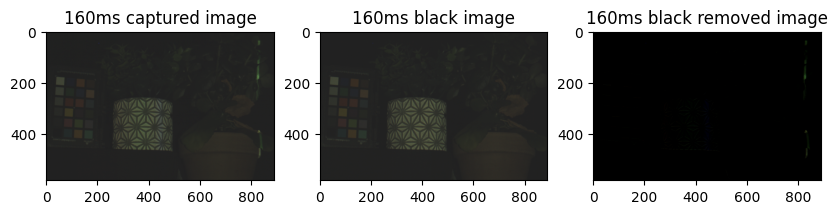

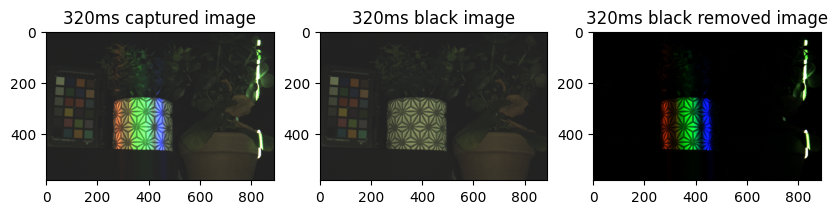

In [16]:
for i in range(len(ldr_images)):
    plt.figure(figsize=(10,5))
    plt.subplot(131),plt.imshow(ldr_images[i]/30000.), plt.title('%sms captured image'%ex_time[i])
    plt.subplot(132), plt.imshow(ldr_black_images[i]/30000.), plt.title('%sms black image'%ex_time[i])
    plt.subplot(133),plt.imshow(ldr_images_bgrm[i]/30000.), plt.title('%sms black removed image'%ex_time[i])
    plt.savefig('bgrm_%02d.svg'%i)

In [17]:
#### 왜 weighted images가 필요한지
weighted_images = [weight_trapezoid[image] for image in ldr_images]
weighted_images_bgrm = [weight_trapezoid_bgrm[image] for image in ldr_images_bgrm]

weighted_images_final = np.minimum(weighted_images, weighted_images_bgrm)

# exposure weight, radiance weight 
# normalization 및 weight multiplication
radiance_images = [np.multiply(weighted_images_final[i], ldr_images_bgrm[i] / (radiance_weight[i] * exposure[i])) for i in range(len(ldr_images_bgrm))]

weight_sum_image = np.sum(weighted_images_final, axis=0)
radiance_sum_image = np.sum(radiance_images, axis=0)

idx_invalid = (weight_sum_image == 0)
weight_sum_image[idx_invalid] = 1
radiance_sum_image[idx_invalid] = 0 

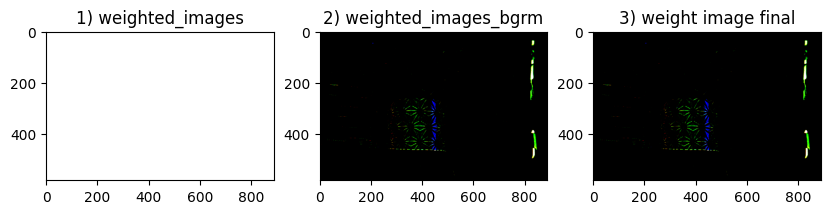

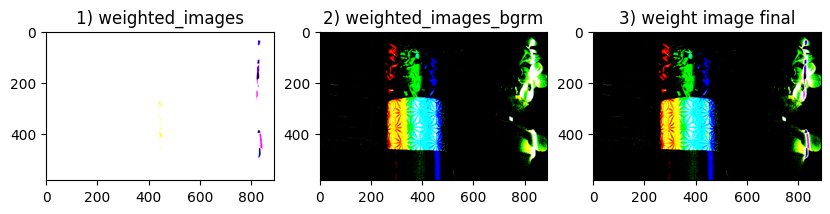

In [18]:
for i in range(len(ldr_images)):
    plt.figure(figsize = (10,5))
    plt.subplot(131), plt.imshow(weighted_images[i]), plt.title('1) weighted_images')
    plt.subplot(132), plt.imshow(weighted_images_bgrm[i]), plt.title('2) weighted_images_bgrm')
    plt.subplot(133), plt.imshow(weighted_images_final[i]), plt.title('3) weight image final')
    plt.savefig('weight_%02d.svg'%i)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


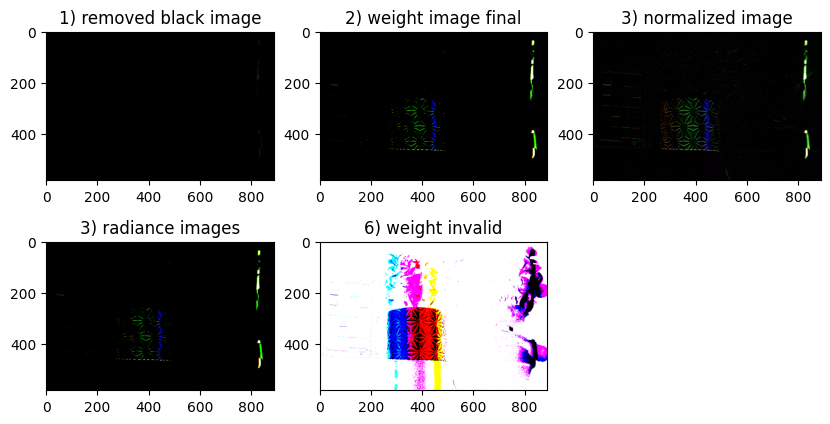

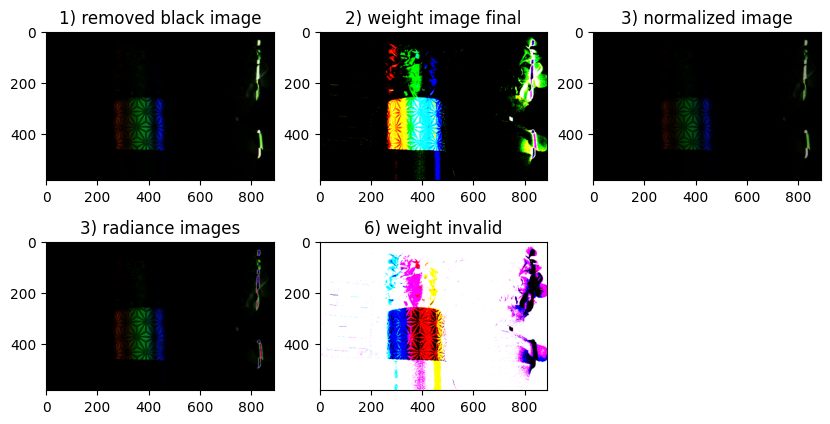

In [19]:
for i in range(len(ldr_images)):
    plt.figure(figsize = (10,5))
    plt.subplot(231), plt.imshow(ldr_images_bgrm[i] /65535), plt.title('1) removed black image')
    plt.subplot(232), plt.imshow(weighted_images_final[i]), plt.title('2) weight image final')
    plt.subplot(233), plt.imshow((ldr_images_bgrm[i] / (radiance_weight[i] * exposure[i]))/ 100000), plt.title('3) normalized image')
    plt.subplot(234), plt.imshow(radiance_images[i]/65535), plt.title('3) radiance images')

    plt.subplot(235), plt.imshow(idx_invalid.astype(np.uint8)*255), plt.title('6) weight invalid')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<AxesSubplot:title={'center':'4) HDR / HDR.max()'}>,
 Text(0.5, 1.0, '4) HDR / HDR.max()'))

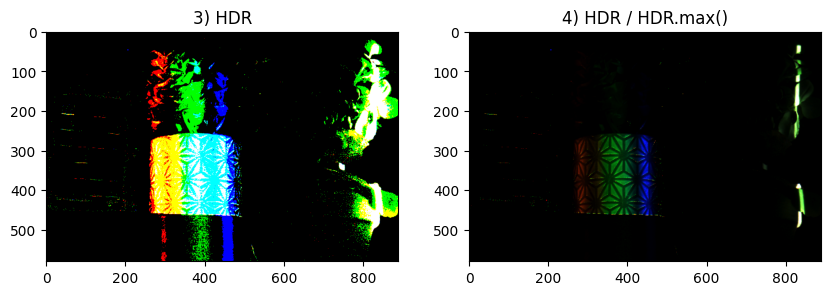

In [20]:
plt.figure(figsize = (10,5))
# plt.subplot(141), plt.imshow(radiance_sum_image), plt.title('1) radiance sum image')
# plt.subplot(142), plt.imshow(weight_sum_image / 3), plt.title('2) weight sum image')
hdr = radiance_sum_image / weight_sum_image
plt.subplot(121), plt.imshow(hdr), plt.title('3) HDR')
plt.subplot(122), plt.imshow(hdr/65535), plt.title('4) HDR / HDR.max()')

In [21]:
hdr_img = np.divide(radiance_sum_image, weight_sum_image)

In [22]:
hdr_img.max(), hdr_img.min()

(482360.1178550383, 0.0)

In [23]:
hdr_img.max()

482360.1178550383

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


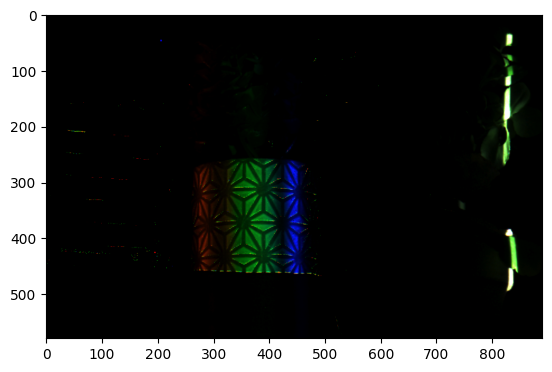

In [24]:
plt.imshow(hdr_img / 65535)

### Make Hdr Image

In [25]:
hdr_imgs = []

# erase black image and get hdr image
for i in range(n_illum):    
    ldr_path = os.path.join(ldr2hdr_dir, 'step2_%sms_crop/calibration00/capture_%04d.png')
    black_path = os.path.join(ldr2hdr_dir, 'step2_%sms_black_crop/calibration00/capture_%04d.png')

    ldr_images = np.array([cv2.imread(ldr_path%(k, i), -1)[:,:,::-1] for k in ex_time])
    ldr_black_images = np.array([cv2.imread(black_path%(k, 0), -1)[:,:,::-1] for k in ex_time])
        
    ldr_images_bgrm = np.clip(safe_subtract(ldr_images, ldr_black_images), 0., 2**16)
    ldr_images_bgrm = ldr_images_bgrm.astype(np.uint16)
            
    hdr_img, invalid_map, weight_map = make_hdr(ldr_images, ldr_images_bgrm, weight_trapezoid, exposure)
    hdr_imgs.append(hdr_img)

    if i % 10 == 0:
        print('%03d-th finished'%i)

hdr_imgs = np.array(hdr_imgs)

000-th finished
010-th finished
020-th finished
030-th finished
040-th finished
050-th finished
060-th finished
070-th finished
080-th finished
090-th finished
100-th finished
110-th finished
120-th finished
130-th finished
140-th finished
150-th finished
160-th finished
170-th finished
180-th finished
190-th finished
200-th finished
210-th finished
220-th finished
230-th finished
240-th finished
250-th finished
260-th finished
270-th finished
280-th finished
290-th finished
300-th finished
310-th finished


### HDR Visualization Check

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


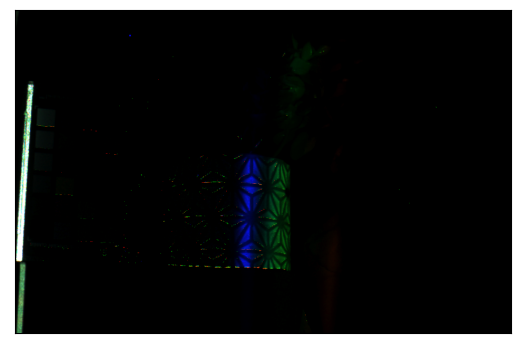

In [29]:
idx = 50
max_val = 65535

fig, ax = plt.subplots()
ax.imshow(hdr_imgs[idx] / (15000))
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.imshow(hdr_imgs[idx] / (65535))
# plt.savefig('./%03d_high.svg'%idx)